# Observing Dark Worlds

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
import math
import edward as ed
import tensorflow as tf
from matplotlib import pyplot as plt

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* halo = []:halos
    * halo[i] :halo for sky i
        * halo[i][0]: sky name
        * halo[i][1]: number of halos
        * halo[i][2]: halo1 x
        * halo[i][3]: halo1 y
        * ...
        * halo[i][7]: halo3 y

In [3]:
path = "~/probp.finalproject/datasets"
#path = "~/Developer/probp.finalproject.darkMatter/datasets"
all_sky_star = []
for sky in np.arange(1,301,1):
    sky_path = "Train_Skies/Training_Sky"+str(sky)+".csv"
    halo_path = "Training_halos.csv"
    star = (pd.read_csv(path+"/"+sky_path).values)
    all_sky_star.append(star)
halo = (pd.read_csv(path+"/"+halo_path).values)

FileNotFoundError: File b'/Users/izaac/probp.finalproject/datasets/Train_Skies/Training_Sky1.csv' does not exist

In [ ]:
#plot e1e2
sky=8
plt.clf()
#plt.scatter(all_sky_star[sky][:,3],all_sky_star[sky][:,4])
#print(halo[sky,2],halo[sky,3])
halos = halo[sky,2:4]
plt.show()

e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
var_e1 = np.var(all_sky_star[sky][:,3])
var_e2 = np.var(all_sky_star[sky][:,4])
print(var_e1)
print(var_e2)
select = a1/b1>2
select = select.reshape(select.shape[0])
pos_xy = all_sky_star[sky][:,1:3]
num = pos_xy.shape[0]
e1_e2 = all_sky_star[sky][:,3:5]
print(num)
pos_all_xy = all_sky_star[0][:,1:3]
pos_all_halo = np.ones(all_sky_star[0][:,1:3].shape)*halo[0,2:4]
pos_all_e1_e2 = all_sky_star[0][:,3:5]
for sky2 in np.arange(1,300,1):
    pos_all_xy = np.concatenate((pos_all_xy,all_sky_star[sky2][:,1:3]),axis = 0)
    pos_all_e1_e2 = np.concatenate((pos_all_e1_e2,all_sky_star[sky2][:,3:5]),axis = 0)
    pos_all_halo = np.concatenate((pos_all_halo,np.ones(all_sky_star[sky2][:,1:3].shape)*halo[sky2,2:4]),axis = 0)
print(pos_all_xy.shape)
print(pos_all_halo.shape)
print(pos_all_e1_e2.shape)

# dist checks

(530,)
(530,)


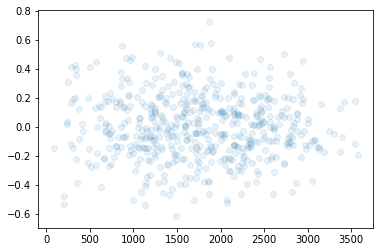

In [35]:
# long/short vs distance
e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
#print(a1/b1)
gal_x = np.array(all_sky_star[sky][:,1],dtype=np.float32)
gal_y = np.array(all_sky_star[sky][:,2],dtype=np.float32)

l2dist = np.sqrt((gal_x-halo[sky,2])**2+(gal_y-halo[sky,3])**2)
# angle vs angle
#print(l2dist)
plt.scatter(l2dist,e2,alpha=0.1)
print(l2dist.shape)
a_b = (a1/b1).reshape(a1.shape[0])
fun = l2dist*a_b
print(fun.shape)
#plt.hist(fun,100)
plt.show()
#times angle

# Delving into model: A study on L2 diff distrubtion

[1.7531934268670832 0.22145261458318366 0.966255656619313 ...,
 1.4044716284523746 3.3896790986015324 1.4134459839936373]
1.5067277043827012


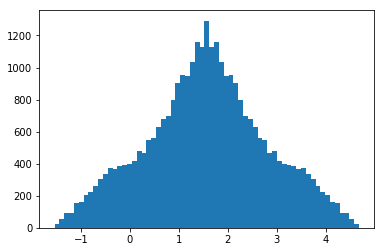

In [114]:

def calc_phi(glxy_position, halo_position):
    delta = glxy_position - halo_position
    delta = delta.astype(np.float64, copy=False)
    t = np.arctan2(delta[:,1], delta[:,0])
    return t
e = np.array(pos_all_e1_e2, dtype=np.float64)
theta = np.arctan2(e[:,1],e[:,0])/2
phi = calc_phi(pos_all_xy, pos_all_halo)

l2diff = np.sum(np.square(pos_all_xy - pos_all_halo), axis=1) ** 0.5
l2diff = l2diff.reshape((l2diff.shape[0],1))
z = theta - phi
z = z.reshape((z.shape[0],1))

l2_e = np.hstack((l2diff, np.abs(z)))

select = (l2_e[:,0] > 3000) & (l2_e[:,0] < 5000)
z = l2_e[select,1]
print(z)
m = np.pi/2.
z = z[z > m]
z = np.concatenate((z,2*m-z))
print(z.var())
plt.clf()
plt.hist(z, bins='auto')
plt.show()


# Model

In [84]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num

# Model

X = tf.placeholder(tf.float32, [N, 2])
X_e1 = e1_e2[:,:1].reshape(N).tolist()
X_e2 = e1_e2[:,1:].reshape(N).tolist()

Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
# Xh = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
# Xh = [2315.61, 1082.86]
m = Uniform(low=100.,high=500.)
sigma = tf.constant(.05)

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))

sess = ed.get_session()

mu = m / tf.maximum(l2diff, 240.)

print(sess.run(sigma))
e1 = Normal(loc = tangential(X, Xh, 0), scale = sigma)
e2 = Normal(loc = tangential(X, Xh, 1), scale = sigma)


0.05


# Model Checks

In [259]:
lz = []
for i in range(N):
    if z[i] < 500:
        print(i,z[i],pos_xy[i])
        lz.append(i)
        
#for t in lz:
#    print('obs:', X_e1[t] / X_e2[t] , sess.run(l2diff, {X:pos_xy})[t])
#    x0 = tangential(X, Xh, 0)
#    y0 = tangential(X, Xh, 1)
#    print('mean:', sess.run(x0, {X:pos_xy})[t] / sess.run(y0, {X:pos_xy})[t])
    
f_x = pos_xy[lz]

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

# Inference

## Variational Inference

In [46]:
def normal_qx():
    return Normal(tf.random_normal([2], mean = 2100.),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))

qXh = normal_qx()
inference = ed.KLqp({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(n_iter=10000, n_samples=10)
# X_post = ed.copy(Xh, {Xh: qXh})

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
print(sess.run([qXh.mean(), qXh.stddev()]))

## MCMC

In [93]:
# Inference
T = 2000
qXh = Empirical(params=tf.Variable(tf.random_uniform([T,2],1000.,3000.)))
qm = Empirical(params=tf.Variable(tf.random_uniform([T],150.,300.)))
#qsig = Empirical(params=tf.Variable(tf.random_uniform([T],0.04,0.06)))
inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(step_size=15.)

2000/2000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.001


# Criticism

[ 184.11909485  295.63452148  290.42462158 ...,  250.04724121  216.62573242
  276.92147827]
[ 2550.23193359  1769.88330078] [  6.55428457  15.6905899 ]


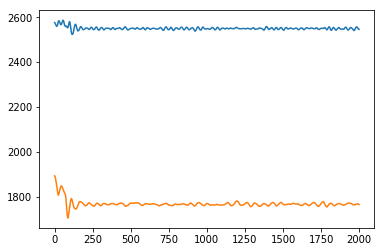

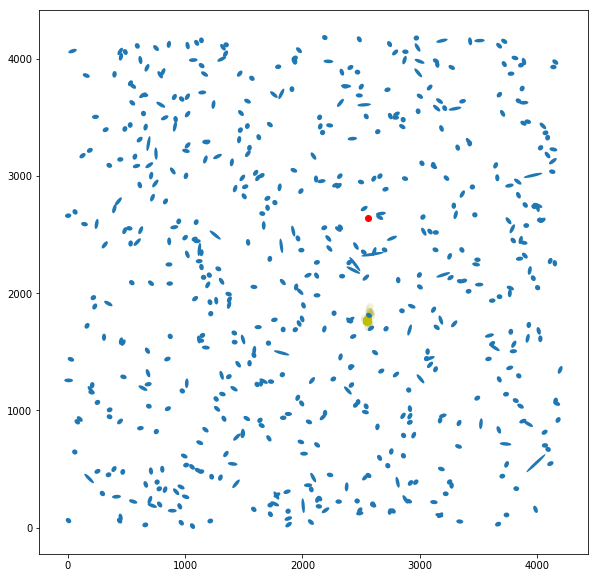

In [95]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
print(sess.run(qm.params))
print(mean, stddev)
samples = sess.run(qXh.params)
#plt.hist(samples, bins='auto')
#plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
plt.scatter(samples[:,0], samples[:,1], alpha = 0.015, c = "y")
plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()

# Criticism 2

10000/10000 [100%] ██████████████████████████████ Elapsed: 24s | Acceptance Rate: 1.000
[ 1389.14172363  1132.78894043] [ 365.77365112  379.37036133]
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 1.000
[ 2324.42089844  2122.41577148] [ 190.08918762   79.93008423]
10000/10000 [100%] ██████████████████████████████ Elapsed: 26s | Acceptance Rate: 1.000
[ 2583.73632812  2554.27050781] [ 238.19967651   61.91926193]
10000/10000 [100%] ██████████████████████████████ Elapsed: 21s | Acceptance Rate: 1.000
[  446.63668823  3190.67089844] [  4.72938299  12.28890228]
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 1.000
[ 2318.93798828  2099.44433594] [ 143.41340637  186.87150574]
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 1.000
[ 2396.44921875  2159.68261719] [ 97.43097687  78.55445099]
10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 1.000
[ 2346.40771484 

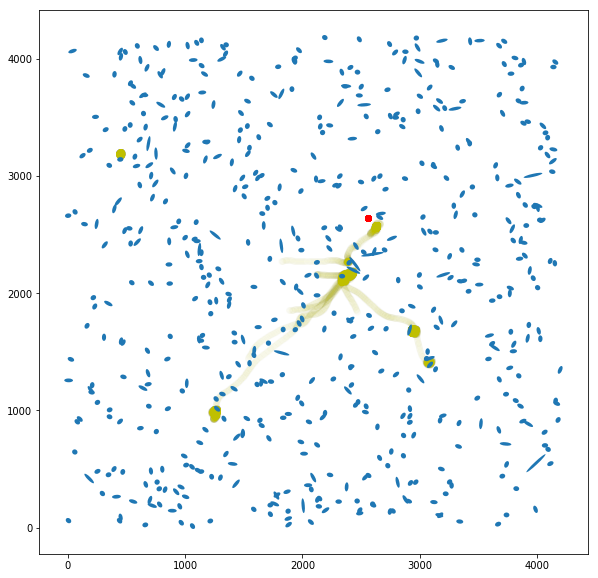

In [63]:
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
for i in np.arange(400,4001,1000):
    for j in np.arange(400,4001,1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2], mean=[i, j],stddev=1.)), 0), 4200)

        T = 10000
        qXh = Empirical(params=constraints_normal(T))
        #qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
        inference.run(step_size=5.)

        mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
        print(mean, stddev)
        samples = sess.run(qXh.params)
        #plt.hist(samples, bins='auto')
        #plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()


        plt.scatter(samples[200:,0], samples[200:,1], alpha = 0.015, c = "y")
        plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()

# Example

In [25]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

# print(pos_all_xy.shape)
# print(pos_all_halo.shape)
# print(pos_all_e1_e2.shape)
N = pos_all_xy.shape[0]

# Model

X = tf.placeholder(tf.float32, [N, 2])
X_e1 = pos_all_e1_e2[:,:1].reshape(N).tolist()
X_e2 = pos_all_e1_e2[:,1:].reshape(N).tolist()

# Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
Xh = tf.placeholder(tf.float32, [N, 2])
# Xh = [2315.61, 1082.86]
#m = Uniform(low=10.,high=1000.)
m= tf.constant(1.)

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))/4200.

sess = ed.get_session()

w0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b0 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
w2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
b3 = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=(l2diff**(-1)+b0)*w0+(l2diff**(1)+b1)*w1 + (l2diff**(2)+b2)*w2 + b3, scale=tf.ones(N))
mu = m / y

e1_var = tf.multiply(tangential(X, Xh, 0),mu)
e2_var = tf.multiply(tangential(X, Xh, 1),mu)

print(sess.run(e1_var,{X: pos_all_xy.tolist(), Xh : pos_all_halo.tolist()})[:10])
print(X_e1[:10])

[-0.8787027   0.87773722 -0.21192177 -0.2273882  -0.45488897  1.04863477
 -2.0123806  -0.14821216  2.84245038  0.80284011]
[-0.050569, -0.248973, 0.483764, -0.043463999999999996, -0.102021, -0.234802, -0.185349, -0.410029, -0.07373099999999999, 0.180122]


In [6]:
qw0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
             
inference = ed.KLqp({w0: qw0, b0: qb0, w1: qw1, b1: qb1, w2: qw2, b2: qb2, b3: qb3}, data={X: pos_all_xy.tolist(), e1_var:X_e1, e2_var:X_e2, Xh : pos_all_halo.tolist()})
inference.run(n_samples=5, n_iter=100)

100/100 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 0.000


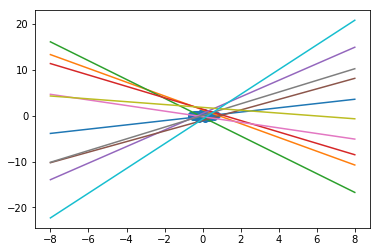

[ 23.10287476  -0.91216576  -0.23557788  -1.91401446  -0.47470939
  -0.80609763   1.56572306  -0.34153977  -0.31368241   0.55340815]


In [29]:
def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples)[:, 0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)
    plt.show()
visualise(e1_e2[:,:1], e1_e2[:,1:], qw0, qb0)

e1_post = ed.copy(e1_var, {w0: qw0, b0: qb0, w1: qw1, b1: qb1, w2: qw2, b2: qb2, b3: qb3})
print(sess.run(e1_post,{X: pos_all_xy.tolist(), Xh : pos_all_halo.tolist()})[:10])

In [209]:
# w_samples = qw1.sample(100000)[:, 0].eval()
# plt.hist(w_samples,500)
# plt.show()
# w_samples = w1.sample(100000)[:, 0].eval()
# plt.hist(w_samples,500)
# plt.show()
#print(e1_var)
sess2.run(e1_var )

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_59' with dtype float and shape [160842,2]
	 [[Node: Placeholder_59 = Placeholder[dtype=DT_FLOAT, shape=[160842,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_59', defined at:
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-9228222d861a>", line 26, in <module>
    Xh = tf.placeholder(tf.float32, [N, 2])
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_59' with dtype float and shape [160842,2]
	 [[Node: Placeholder_59 = Placeholder[dtype=DT_FLOAT, shape=[160842,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

In [148]:
e1_e2 = e1_e2.astype(np.float64, copy=False)
theta0 = np.arctan2(e1_e2[:,1], e1_e2[:,0]) / 2.

# Model II

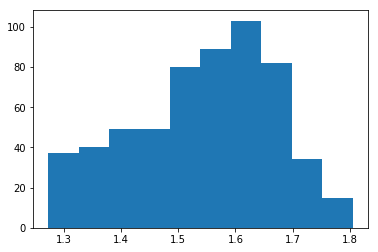

In [155]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def calc_phi(glxy_position, halo_position):
    delta = glxy_position - halo_position
    t = tf.atan2(delta[:,1], delta[:,0])
    return t

N = num

# Model

X = tf.placeholder(tf.float32, [N, 2])
theta_0 = tf.placeholder(tf.float32, [N])

Xh = Uniform(low=[0.,0.],high=[4200., 4200.])

phi = calc_phi(X, Xh)
r = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))

sigma = tf.constant(0.00010816) * r + tf.constant(1.25309)

phi_1 = Normal(-np.pi/2., sigma)
phi_2 = Normal(np.pi/2., sigma)
theta = theta_0 + phi_1 + phi_2

sess = ed.get_session()
l = (sess.run(sigma,{X:pos_xy, theta_0: theta0}))
plt.hist(l)
plt.show()

# Inference II

In [1]:
# Inference
T = 2000
qXh = Empirical(params=tf.Variable(tf.random_uniform([T,2],2000.,1000.)))
inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, theta_0:np.arctan2(e1_e2[:,1], e1_e2[:,0]) / 2.})
inference.run(step_size=15.)

NameError: name 'Empirical' is not defined

# Criticism II

[ 2205.51806641  2697.67871094] [ 180.35942078  177.71020508]


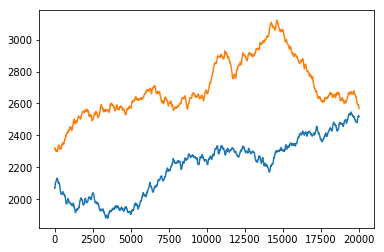

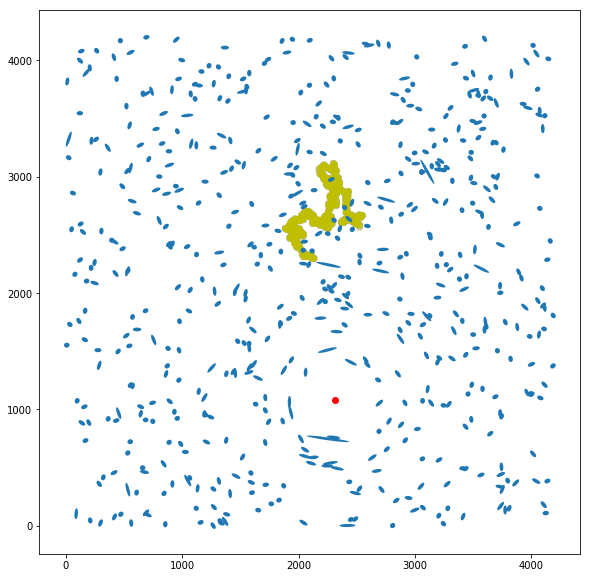

In [142]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
print(mean, stddev)
samples = sess.run(qXh.params)
#plt.hist(samples, bins='auto')
#plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
plt.scatter(samples[:,0], samples[:,1], alpha = 0.015, c = "y")
plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()